# Análisis del dataset de las emisiones de CO2 per cápita: *'co-emissions-per-capita.csv'*

Cargamos los módulos necesarios:

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
import requests
import json
from lxml import etree
from bs4 import BeautifulSoup
import math as m
import csv
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster
import xml.etree.ElementTree as E
#import wget

Leemos el archivo y mostramos su cabecera:

In [2]:
df_co2 = pd.read_csv('co-emissions-per-capita.csv')
df_co2.head()

,Entity,Code,Year,Annual CO2 emissions (per capita)
0,Afghanistan,AFG,1949,0.0019
1,Afghanistan,AFG,1950,0.0109
2,Afghanistan,AFG,1951,0.0117
3,Afghanistan,AFG,1952,0.0115
4,Afghanistan,AFG,1953,0.0132


Veamos qué variables contiene:

In [3]:
# Select variables
columns_level = list(df_co2.columns.values)
columns_level

['Entity', 'Code', 'Year', 'Annual CO2 emissions (per capita)']

Para cada una de las variables, mostramos sus valores únicos:

In [4]:
# Show unique values for variables. Discrete? Continuous?
# Select variables
columns_level = list(df_co2.columns.values)
for column in columns_level:
    print('Unique values for column ' + column + ':')
    temp  = df_co2[column].unique()
    print(len(temp))
    print(temp)
    print('\n')

Unique values for column Entity:
230
['Afghanistan' 'Africa' 'Albania' 'Algeria' 'Andorra' 'Angola' 'Anguilla'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Asia'
 'Asia (excl. China & India)' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bermuda' 'Bhutan' 'Bolivia' 'Bonaire Sint Eustatius and Saba'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'British Virgin Islands'
 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon'
 'Canada' 'Cape Verde' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo' 'Cook Islands' 'Costa Rica' "Cote d'Ivoire"
 'Croatia' 'Cuba' 'Curacao' 'Cyprus' 'Czechia'
 'Democratic Republic of Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'EU-27' 'EU-28' 'Ecuador' 'Egypt' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Europe'
 'Europe (excl. EU-27)' 'Europe (excl. EU-28)' 'Faeroe Islands' 'Fiji'
 'Finlan

Veamos cuáles son los tipos de cada variable:

In [5]:
df_co2.dtypes

Entity                                object
Code                                  object
Year                                   int64
Annual CO2 emissions (per capita)    float64
dtype: object

## Obtención de metadatos.

La fuente de este trabajo es *Integrated Carbon Observation System*, que no sofrece dos identificadores. El primero de ellos: 10.18160/gcp-2021. Emplearemos diferentes resolvedores. 

Con resolvedor HANDLE, aceptamos respuestas de tipo XML:

In [6]:
resolver = "http://hdl.handle.net/"
doi = "10.18160/gcp-2021"
headers = {'Content-Type': 'application/xml'}
r_1 = requests.get(resolver + doi)           
print("Status code: %s" % r_1.status_code)

Status code: 200


In [8]:
r_1.text

'<!DOCTYPE html>\n<html lang="en" dir="ltr" prefix="content: http://purl.org/rss/1.0/modules/content/  dc: http://purl.org/dc/terms/  foaf: http://xmlns.com/foaf/0.1/  og: http://ogp.me/ns#  rdfs: http://www.w3.org/2000/01/rdf-schema#  schema: http://schema.org/  sioc: http://rdfs.org/sioc/ns#  sioct: http://rdfs.org/sioc/types#  skos: http://www.w3.org/2004/02/skos/core#  xsd: http://www.w3.org/2001/XMLSchema# ">\n  <head>\n    <meta charset="utf-8" />\n<link rel="canonical" href="https://www.icos-cp.eu/science-and-impact/global-carbon-budget/2021" />\n<meta name="description" content="Contact info:\xa0info@globalcarbonproject.org\n\narticle doi: https://doi.org/10.5194/essd-2021-386\n\ndata doi: 10.18160/gcp-2021\xa0(this page)\n\n\xa0" />\n<meta property="og:site_name" content="ICOS" />\n<meta property="og:url" content="https://www.icos-cp.eu/science-and-impact/global-carbon-budget/2021" />\n<meta property="og:title" content="Data supplement to the Global Carbon Budget 2021" />\n<me

Si bien, no podemos parsear su respuesta de forma adecuada. Observemos el error: el árbol xml no está bien formado.

In [10]:
with open("co2_metadata.xml", "wb") as f:
    f.write(r_1.content)

In [11]:
co2_tree = ET.parse("co2_metadata.xml")

ParseError: not well-formed (invalid token): line 55, column 76 (<string>)

Aceptamos json:

In [12]:
resolver = "http://hdl.handle.net/"
doi = "10.18160/gcp-2021"
headers = {'Accept': 'application/json'} #Type of response accpeted
r_2 = requests.get(resolver + doi)           
print("Status code: %s" % r_2.status_code)

Status code: 200


In [13]:
r_2.content

b'<!DOCTYPE html>\n<html lang="en" dir="ltr" prefix="content: http://purl.org/rss/1.0/modules/content/  dc: http://purl.org/dc/terms/  foaf: http://xmlns.com/foaf/0.1/  og: http://ogp.me/ns#  rdfs: http://www.w3.org/2000/01/rdf-schema#  schema: http://schema.org/  sioc: http://rdfs.org/sioc/ns#  sioct: http://rdfs.org/sioc/types#  skos: http://www.w3.org/2004/02/skos/core#  xsd: http://www.w3.org/2001/XMLSchema# ">\n  <head>\n    <meta charset="utf-8" />\n<link rel="canonical" href="https://www.icos-cp.eu/science-and-impact/global-carbon-budget/2021" />\n<meta name="description" content="Contact info:\xc2\xa0info@globalcarbonproject.org\n\narticle doi: https://doi.org/10.5194/essd-2021-386\n\ndata doi: 10.18160/gcp-2021\xc2\xa0(this page)\n\n\xc2\xa0" />\n<meta property="og:site_name" content="ICOS" />\n<meta property="og:url" content="https://www.icos-cp.eu/science-and-impact/global-carbon-budget/2021" />\n<meta property="og:title" content="Data supplement to the Global Carbon Budget 

No obtenemos el resultado deseado, 

Probemos a utilizar el resolvedror DOI. Aceptando xml:

In [15]:
resolver = "https://doi.org/"
doi = "10.18160/gcp-2021"
headers = {'Content-Type': 'application/xml'}
r_3 = requests.get(resolver + doi)           
print("Status code: %s" % r_3.status_code)

Status code: 200


In [16]:
r_3.content

b'<!DOCTYPE html>\n<html lang="en" dir="ltr" prefix="content: http://purl.org/rss/1.0/modules/content/  dc: http://purl.org/dc/terms/  foaf: http://xmlns.com/foaf/0.1/  og: http://ogp.me/ns#  rdfs: http://www.w3.org/2000/01/rdf-schema#  schema: http://schema.org/  sioc: http://rdfs.org/sioc/ns#  sioct: http://rdfs.org/sioc/types#  skos: http://www.w3.org/2004/02/skos/core#  xsd: http://www.w3.org/2001/XMLSchema# ">\n  <head>\n    <meta charset="utf-8" />\n<link rel="canonical" href="https://www.icos-cp.eu/science-and-impact/global-carbon-budget/2021" />\n<meta name="description" content="Contact info:\xc2\xa0info@globalcarbonproject.org\n\narticle doi: https://doi.org/10.5194/essd-2021-386\n\ndata doi: 10.18160/gcp-2021\xc2\xa0(this page)\n\n\xc2\xa0" />\n<meta property="og:site_name" content="ICOS" />\n<meta property="og:url" content="https://www.icos-cp.eu/science-and-impact/global-carbon-budget/2021" />\n<meta property="og:title" content="Data supplement to the Global Carbon Budget 

Aceptando json:

In [18]:
resolver = "https://doi.org/"
doi = "10.18160/gcp-2021"
headers = {'Accept': 'application/json'} #Type of response accpeted
r_4 = requests.get(resolver + doi)           
print("Status code: %s" % r_4.status_code)

Status code: 200


In [19]:
r_4.content

b'<!DOCTYPE html>\n<html lang="en" dir="ltr" prefix="content: http://purl.org/rss/1.0/modules/content/  dc: http://purl.org/dc/terms/  foaf: http://xmlns.com/foaf/0.1/  og: http://ogp.me/ns#  rdfs: http://www.w3.org/2000/01/rdf-schema#  schema: http://schema.org/  sioc: http://rdfs.org/sioc/ns#  sioct: http://rdfs.org/sioc/types#  skos: http://www.w3.org/2004/02/skos/core#  xsd: http://www.w3.org/2001/XMLSchema# ">\n  <head>\n    <meta charset="utf-8" />\n<link rel="canonical" href="https://www.icos-cp.eu/science-and-impact/global-carbon-budget/2021" />\n<meta name="description" content="Contact info:\xc2\xa0info@globalcarbonproject.org\n\narticle doi: https://doi.org/10.5194/essd-2021-386\n\ndata doi: 10.18160/gcp-2021\xc2\xa0(this page)\n\n\xc2\xa0" />\n<meta property="og:site_name" content="ICOS" />\n<meta property="og:url" content="https://www.icos-cp.eu/science-and-impact/global-carbon-budget/2021" />\n<meta property="og:title" content="Data supplement to the Global Carbon Budget 

No obtenemos los resultados deseados y, puede comprobarse, no podemos parsearlo con los métodos vistos en clase. 

Si bien, se nos ofrece también un identificado en zenodo: 10.5281/zenodo.5569235. Intentemos resolverlo:

In [20]:
resolver = "https://doi.org/"
doi = "10.1787/36bce3fe-en"
headers = {'Content-Type': 'application/xml'}
r_5 = requests.get(resolver + doi, headers=headers)                    # POST with headers
print("Status code: %s" % r_5.status_code)
if  r_5.status_code == 200:
    with open("co2_metadata.xml", "wb") as f:
        f.write(r_5.content)
ET.parse("co2_metadata.xml")

Status code: 403


ParseError: not well-formed (invalid token): line 55, column 76 (<string>)

In [35]:
resolver = "https://doi.org/"
doi = "10.18160/gcp-2021"
headers = {'Accept': 'application/json'} #Type of response accpeted
r_6 = requests.get(resolver + doi, headers=headers)                    # POST with headers
print("Status code: %s" % r_6.status_code)

Status code: 502


In [36]:
r_6.content

b'<html>\r\n<head><title>502 Bad Gateway</title></head>\r\n<body>\r\n<center><h1>502 Bad Gateway</h1></center>\r\n</body>\r\n</html>\r\n'

Tampoco obtenemos el resultado deseado.

In [24]:
resolver = "http://hdl.handle.net/"
doi = "https://doi.org/10.5281/zenodo.5569235"
headers = {'Content-Type': 'application/xml'}
r_7 = requests.get(resolver + doi)           
print("Status code: %s" % r_7.status_code)
if  r_4.status_code == 200:
    with open("co2_metadata.xml", "wb") as f:
        f.write(r_7.content)
ET.parse("co2_metadata.xml")

Status code: 200


ParseError: mismatched tag: line 54, column 4 (<string>)

In [ ]:
Con resolvedor DOI:

In [28]:
resolver = "https://doi.org/"
doi = "https://doi.org/10.5281/zenodo.5569235"
headers = {'Accept': 'application/json'} #Type of response accpeted
r_8 = requests.get(resolver + doi, headers=headers)                    # POST with headers
print("Status code: %s" % r_8.status_code)

KeyboardInterrupt: 

In [ ]:
r_8.content

In [ ]:
def show_childs(l):
    """
    Given a list of xml.etree.ElementTree.Element class elements,
    gets all instaces of child nodes amd print tags and text content.
    
    Parameters
    ----------
    l : list of xml.etree.ElementTree.Element
    
    Returns
    -------
    None
    
    Raises
    ------
    None    
    """
    for elem in l:
        if elem.getchildren():
            for child in elem.getchildren():
                show_childs([child])
        else:
            print(elem.tag.split('}')[1] + ': ' + elem.text)

En ningún caso hemos obtenido resultados que puedan ser analizados con los métodos vistos en clase. SI bien, podekos intentar emplear HTML.

Creamos un parser (ver https://docs.python.org/es/3.8/library/html.parser.html):

In [39]:
from html.parser import HTMLParser
from html.entities import name2codepoint

class MyHTMLParser(HTMLParser):
    def handle_starttag(self, tag, attrs):
        print("Start tag:", tag)
        for attr in attrs:
            print("     attr:", attr)

    def handle_endtag(self, tag):
        print("End tag  :", tag)

    def handle_data(self, data):
        print("Data     :", data)

    def handle_comment(self, data):
        print("Comment  :", data)

    def handle_entityref(self, name):
        c = chr(name2codepoint[name])
        print("Named ent:", c)

    def handle_charref(self, name):
        if name.startswith('x'):
            c = chr(int(name[1:], 16))
        else:
            c = chr(int(name))
        print("Num ent  :", c)

    def handle_decl(self, data):
        print("Decl     :", data)

parser = MyHTMLParser()

In [40]:
resolver = "http://hdl.handle.net/"
doi = "10.18160/gcp-2021"
headers = {'Content-Type': 'application/xml'} # set what your server accepts
my_r = requests.get(resolver + doi)                    #GET with headers
print("Status code: %s" % my_r.status_code)

Status code: 200


In [42]:
parser.feed(my_r.text)

Decl     : DOCTYPE html
Data     : 

Start tag: html
     attr: ('lang', 'en')
     attr: ('dir', 'ltr')
     attr: ('prefix', 'content: http://purl.org/rss/1.0/modules/content/  dc: http://purl.org/dc/terms/  foaf: http://xmlns.com/foaf/0.1/  og: http://ogp.me/ns#  rdfs: http://www.w3.org/2000/01/rdf-schema#  schema: http://schema.org/  sioc: http://rdfs.org/sioc/ns#  sioct: http://rdfs.org/sioc/types#  skos: http://www.w3.org/2004/02/skos/core#  xsd: http://www.w3.org/2001/XMLSchema# ')
Data     : 
  
Start tag: head
Data     : 
    
Start tag: meta
     attr: ('charset', 'utf-8')
End tag  : meta
Data     : 

Start tag: link
     attr: ('rel', 'canonical')
     attr: ('href', 'https://www.icos-cp.eu/science-and-impact/global-carbon-budget/2021')
End tag  : link
Data     : 

Start tag: meta
     attr: ('name', 'description')
     attr: ('content', 'Contact info:\xa0info@globalcarbonproject.org\n\narticle doi: https://doi.org/10.5194/essd-2021-386\n\ndata doi: 10.18160/gcp-2021\xa0(thi

Start tag: li
     attr: ('class', 'is_topnode')
Data     : 
									
Start tag: div
     attr: ('class', 'menu-item-text')
Data     : 
						
Start tag: span
     attr: ('class', 'open_menu menu-icon')
Start tag: i
     attr: ('class', 'fas fa-chevron-down')
End tag  : i
End tag  : span
Data     : 
																
Start tag: a
     attr: ('href', '/data-services')
     attr: ('class', '')
Data     : 
											Data & Services
														
End tag  : a
Data     : 
									
End tag  : div
Data     : 
																				
Start tag: ul
Data     : 
										
Start tag: li
Data     : 
																
Start tag: a
     attr: ('href', '/data-services/about-data-portal')
     attr: ('class', '')
Data     : 
											ICOS Data Portal
															
Start tag: span
     attr: ('class', 'open_menu submenu-icon')
Start tag: i
     attr: ('class', 'fas fa-chevron-right')
End tag  : i
End tag  : span
Data     : 
									
End tag  : a
Data     : 
																				
Start tag: ul
Data  

     attr: ('data-highlight-on-scroll', '0')
     attr: ('data-highlight-offset', '100')
     attr: ('data-sticky', '0')
     attr: ('data-sticky-offset', '0')
     attr: ('data-sticky-stop', '')
     attr: ('data-sticky-stop-padding', '0')
Data     : 
  
Start tag: div
     attr: ('class', 'toc-title h2')
Data     : On this page:
End tag  : div
Data     : 
  
Start tag: nav
     attr: ('role', 'navigation')
     attr: ('aria-label', 'On this page:')
End tag  : nav
Data     : 

End tag  : div
Data     : 

    
End tag  : div
Data     : 
  
End tag  : div
Data     : 

Start tag: div
     attr: ('class', 'block block-layout-builder block-field-blocknodepagebody')
Data     : 
  
    
      
Start tag: div
     attr: ('class', 'content')
Data     : 
      
            
Start tag: div
     attr: ('property', 'schema:text')
     attr: ('class', 'clearfix text-formatted field field--name-body field--type-text-with-summary field--label-hidden field__item')
Start tag: p
Data     : Contact info:

Nuevamente, obtenemos un resultado dificil de manejar. Probamos utilizar `BeutifulSoup`

In [43]:
soup = BeautifulSoup(my_r.content, 'html.parser')

In [44]:
# Get all HTML tags with Beautiful Soup
set([tag.name for tag in soup.find_all()])

{'a',
 'article',
 'aside',
 'body',
 'div',
 'em',
 'footer',
 'form',
 'h1',
 'h2',
 'h3',
 'h4',
 'head',
 'header',
 'html',
 'i',
 'img',
 'input',
 'label',
 'li',
 'link',
 'main',
 'meta',
 'nav',
 'ol',
 'p',
 'script',
 'section',
 'span',
 'strong',
 'title',
 'ul'}

Recurramos agunas etiquetas:

In [45]:
for elem in soup.find_all('article'):
    print(elem)    

<article about="/science-and-impact/global-carbon-budget/2021" class="node node--type-page node--view-mode-full clearfix" data-history-node-id="1090" role="article" typeof="schema:WebPage">
<header>
<span class="rdf-meta hidden" content="Data supplement to the Global Carbon Budget 2021" property="schema:name"></span>
<span class="rdf-meta hidden" content="UserComments:0" property="schema:interactionCount"></span>
</header>
<div class="node__content clearfix">
<div class="layout layout--onecol">
<div class="layout__region layout__region--content">
<div class="block block-layout-builder block-field-blocknodepagefield-header-image">
<div class="content">
<div class="field field--name-field-header-image field--type-image field--label-hidden field__item"> <img alt="GCP banner" height="141" loading="lazy" src="/sites/default/files/2021-11/GCP_banner_1100px%20%281%29.png" typeof="foaf:Image" width="1170"/>
</div>
</div>
</div>
</div>
</div>
<div class="layout layout--twocol-section layout--tw

In [47]:
for link in soup.find_all('a'):
    print(link.get('href'))

#main-content
/about/contact
None
None
/
/
/
/about
/about/icos-in-nutshell
/about/icos-in-nutshell/mission
/about/icos-in-nutshell/strategy
/about/icos-in-nutshell/abbreviations
/about/organisation-governance
/about/organisation-governance/structure
/about/organisation-governance/icos-eric
/about/organisation-governance/member-countries
/about/organisation-governance/international-cooperation
/about/join-icos
/about/join-icos/benefits
/about/join-icos/process-countries
/about/join-icos/process-stations
/about/opportunities
/about/opportunities/careers
/about/opportunities/summer-school
/about/contact
/about/contact/head-office-central-facilities
/about/contact/national-networks
/about/contact/media
/about/contact/invite-speaker
/about/contact/faq
/about/contact/feedback
/observations
/observations/atmosphere
/observations/atmosphere/stations
/observations/atmosphere/atc
/observations/atmosphere/cal
/observations/ecosystem
/observations/ecosystem/stations
/observations/ecosystem/etc
/o

In [48]:
for paragraph in soup.find_all('p'):
    print(paragraph)

<p class="header-links"><a class="header-link" href="/about/contact">Contact</a> <span class="account header-link accountLnk"><a>My Account</a></span> <span class="header-link logInLnk"><a>Log in</a></span></p>
<p>Contact info: <strong><a href="mailto:info@globalcarbonproject.org">info@globalcarbonproject.org</a></strong></p>
<p>article doi: <a href="https://doi.org/10.5194/essd-2021-386" target="_blank" title="https://doi.org/10.5194/essd-2021-386">https://doi.org/10.5194/essd-2021-386</a></p>
<p>data doi: <a href="https://doi.org/10.18160/gcp-2021">10.18160/gcp-2021</a> (this page)</p>
<p> </p>
<p>Citation: <strong>Global Carbon Project. (2021). Supplemental data of Global Carbon Budget 2021 (Version 1.0) [Data set]. Global Carbon Project. <a href="https://doi.org/10.18160/gcp-2021">https://doi.org/10.18160/gcp-2021</a></strong> </p>
<p> </p>
<p><a href="https://data.icos-cp.eu/collections/r3Q-8pmI4TtYTP38Rnrh9nH-" target="_blank">Both GCP 2021 spreadsheets</a> from below in one sing

In [49]:
soup.find_all('meta')

[<meta charset="utf-8"/>,
 <meta content="Contact info: info@globalcarbonproject.org
 
 article doi: https://doi.org/10.5194/essd-2021-386
 
 data doi: 10.18160/gcp-2021 (this page)
 
  " name="description"/>,
 <meta content="ICOS" property="og:site_name"/>,
 <meta content="https://www.icos-cp.eu/science-and-impact/global-carbon-budget/2021" property="og:url"/>,
 <meta content="Data supplement to the Global Carbon Budget 2021" property="og:title"/>,
 <meta content="Contact info: info@globalcarbonproject.org
 
 article doi: https://doi.org/10.5194/essd-2021-386
 
 data doi: 10.18160/gcp-2021 (this page)
 
  " property="og:description"/>,
 <meta content="summary" name="twitter:card"/>,
 <meta content="Contact info: info@globalcarbonproject.org
 
 article doi: https://doi.org/10.5194/essd-2021-386
 
 data doi: 10.18160/gcp-2021 (this page)
 
  " name="twitter:description"/>,
 <meta content="@ICOS_RI" name="twitter:site"/>,
 <meta content="Data supplement to the Global Carbon Budget 2021" 

A algunos campos podemos acceder fácilmente:

In [50]:
soup.title

<title>Data supplement to the Global Carbon Budget 2021 | ICOS</title>

Por tanto, tendremos que crear los metadatos con la información disponible al parseat el HTML. Consultar los metadatos en el infrome.

# Análisis preliminar:

Consultamos qué países tienen mayores emisiones de CO2 per cápita en 2018:

In [53]:
df_co2_2018 = df_co2[df_co2["Year"] == 2018]

In [54]:
max_2018 = df_co2_2018["Annual CO2 emissions (per capita)"].nlargest(5)

In [55]:
df_co2.loc[max_2018.index]

,Entity,Code,Year,Annual CO2 emissions (per capita)
17134,Qatar,QAT,2018,38.4397
21033,Trinidad and Tobago,TTO,2018,29.1223
5141,Curacao,CUW,2018,23.5257
11552,Kuwait,KWT,2018,23.1008
3381,Brunei,BRN,2018,22.3619


Consultamos las emisiones de CO2 per cápita para Estados Unidos, Canadá y Australia en 2018:

In [56]:
df_co2_2018[df_co2_2018["Entity"].isin(["United States", "Canada", "Australia"])]

,Entity,Code,Year,Annual CO2 emissions (per capita)
1471,Australia,AUS,2018,16.7081
4014,Canada,CAN,2018,15.6299
22262,United States,USA,2018,16.4340


Consultamos la media global en 2018:

In [57]:
np.mean(df_co2_2018["Annual CO2 emissions (per capita)"])

5.033989519650653

Consultamos las emisiones de CO2 per cápita para Francia, Portugal y Reino Unido en 2018:

In [58]:
df_co2_2018[df_co2_2018["Entity"].isin(["France", "Portugal", "United Kingdom"])]

,Entity,Code,Year,Annual CO2 emissions (per capita)
8176,France,FRA,2018,4.9603
17061,Portugal,PRT,2018,5.0206
22041,United Kingdom,GBR,2018,5.6878


Consultamos las emisiones de CO2 per cápita para Alemania, Bélgica y Holanda en 2018:

In [153]:
df_co2_2018[df_co2_2018["Entity"].isin(["Germany", "Belgium", "Netherlands"])]

,Entity,Code,Year,Annual CO2 emissions (per capita)
2520,Belgium,BEL,2018,8.7289
8836,Germany,DEU,2018,9.0721
14454,Netherlands,NLD,2018,9.3215


Consultamos las emisiones de CO2 per cápita para Chad, Niger en 2018:

In [154]:
df_co2_2018[df_co2_2018["Entity"].isin(["Chad", "Niger"])]

,Entity,Code,Year,Annual CO2 emissions (per capita)
4209,Chad,TCD,2018,0.0675
14809,Niger,NER,2018,0.0830


In [156]:
16.7081/365

0.04577561643835617

A continuación, graficamos la evolución histórica de las emisiones de C02 per cápita para ciertos paises. Seleccionar otros si es deseado.

Lista de países:

In [60]:
countries = ["United States", "Australia", "South Africa",
             "China", "United Kingdom", "Spain", "Brazil", "India"]

Filtrado por países:

In [64]:
df_co2_countries = df_co2[df_co2['Entity'].isin(countries)]

Establecemos un nuevo índice:

In [65]:
df_co2_countries.set_index("Year", inplace = True)

Eliminamos la columna 'Entity':

In [66]:
df_co2_countries.drop("Entity", axis = 1)

,Code,Annual CO2 emissions (per capita)
Year,,
1860,AUS,0.2161
1861,AUS,0.3771
1862,AUS,0.2533
1863,AUS,0.2765
1864,AUS,0.1799
...,...,...
2016,USA,16.2469
2017,USA,16.0197
2018,USA,16.4340


Graficamos:

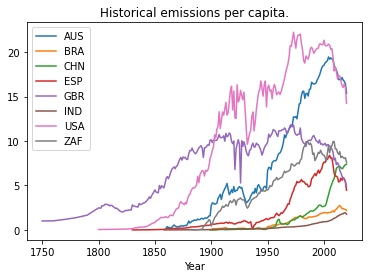

In [67]:
df_co2_countries.groupby('Code')['Annual CO2 emissions (per capita)'].plot(legend = True)
plt.title("Historical emissions per capita.")
plt.savefig('co2.1.png')

Nuestro siguiente objetivo es hacer un mapa interactivo para ver las emisiones per cápita en el año 2018 según el país (https://towardsdatascience.com/using-python-to-create-a-world-map-from-a-list-of-country-names-cd7480d03b10):

In [68]:
df_co2_map = df_co2[df_co2['Year'] == 2018][['Entity', "Annual CO2 emissions (per capita)"]]

In [69]:
df_co2_map

,Entity,Annual CO2 emissions (per capita)
69,Afghanistan,0.2245
206,Africa,1.0865
294,Albania,1.6422
399,Algeria,3.8241
430,Andorra,6.4232
...,...,...
22818,Vietnam,2.3415
23044,World,4.8022
23115,Yemen,0.3503
23186,Zambia,0.4215


Función para convertir los nombres completos de los países a tipo alpha.2:

In [70]:
# Conversion to Alpha 2 codes and continents:
def get_continent(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown' 
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown' 
    return (cn_a2_code, cn_continent)

In [71]:
codes = list(map(get_continent, df_co2_map["Entity"]))

Creamos nuevas columnas:

In [72]:
df_co2_map['Codes'] = codes
df_co2_map['Country'] = list(map(lambda x: x[0], codes))
df_co2_map['Continent'] = list(map(lambda x: x[1], codes))

In [73]:
df_co2_map

,Entity,Annual CO2 emissions (per capita),Codes,Country,Continent
69,Afghanistan,0.2245,"(AF, AS)",AF,AS
206,Africa,1.0865,"(Unknown, Unknown)",Unknown,Unknown
294,Albania,1.6422,"(AL, EU)",AL,EU
399,Algeria,3.8241,"(DZ, AF)",DZ,AF
430,Andorra,6.4232,"(AD, EU)",AD,EU
...,...,...,...,...,...
22818,Vietnam,2.3415,"(VN, AS)",VN,AS
23044,World,4.8022,"(Unknown, Unknown)",Unknown,Unknown
23115,Yemen,0.3503,"(YE, AS)",YE,AS
23186,Zambia,0.4215,"(ZM, AF)",ZM,AF


Obtenemos la latitud y longitud (centro de masas) para cada país:

In [74]:
# Get longitud and latitude
geolocator = Nominatim(user_agent="DLC")
def geolocate(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return np.nan

In [75]:
geolocations = list(map(geolocate, df_co2_map["Country"]))

Añadimos nuevas columnas:

In [77]:
df_co2_map['Geolocate'] = geolocations
df_co2_map['Latitude']  = list(map(lambda x: x[0], geolocations))
df_co2_map['Longitude'] =  list(map(lambda x: x[1], geolocations))

In [65]:
df_co2_map

,Entity,Annual CO2 emissions (per capita),Codes,Country,Continent,Geolocate,Latitude,Longitude
69,Afghanistan,0.2245,"(AF, AS)",AF,AS,"(33.7680065, 66.2385139)",33.768006,66.238514
206,Africa,1.0865,"(Unknown, Unknown)",Unknown,Unknown,"(25.029422, -77.36195598496681)",25.029422,-77.361956
294,Albania,1.6422,"(AL, EU)",AL,EU,"(33.2588817, -86.8295337)",33.258882,-86.829534
399,Algeria,3.8241,"(DZ, AF)",DZ,AF,"(28.0000272, 2.9999825)",28.000027,2.999983
430,Andorra,6.4232,"(AD, EU)",AD,EU,"(42.5407167, 1.5732033)",42.540717,1.573203
...,...,...,...,...,...,...,...,...
22818,Vietnam,2.3415,"(VN, AS)",VN,AS,"(13.2904027, 108.4265113)",13.290403,108.426511
23044,World,4.8022,"(Unknown, Unknown)",Unknown,Unknown,"(25.029422, -77.36195598496681)",25.029422,-77.361956
23115,Yemen,0.3503,"(YE, AS)",YE,AS,"(16.3471243, 47.8915271)",16.347124,47.891527
23186,Zambia,0.4215,"(ZM, AF)",ZM,AF,"(-14.5189121, 27.5589884)",-14.518912,27.558988


Dibujamos el mapa:

In [79]:
#empty map
world_map = folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)
#for each coordinate, create circlemarker of user percent
for i in range(len(df_co2_map)):
        lat = df_co2_map.iloc[i]['Latitude']
        long = df_co2_map.iloc[i]['Longitude']
        radius=  5
        popup_text = """Country : {}<br>
                    % CO2 per capita : {}<br>"""
        popup_text = popup_text.format(df_co2_map.iloc[i]['Country'],
                                   df_co2_map.iloc[i]['Annual CO2 emissions (per capita)']
                                   )
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
#show the map
world_map
